In [189]:
# !git clone https://github.com/9Tribez17/QF_Group12.git

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

## Data Preprocess

In [2]:
data = pd.read_csv('data/text_add_v3.csv')
data_ori = pd.read_csv('data/clean_churn.csv')

In [3]:
# Check the objective column is in the data_feature
print('Exited' in data.columns)

True


In [4]:
data_ori.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0.0,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0.0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0.0,1
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0.0,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0.0,1


In [5]:
data.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,Balance_NumOfProducts_difference,EstimatedSalary_NumOfProducts_difference,CreditScore_NumOfProducts_difference,CustomerId_NumOfProducts_difference,Age_CustomerId_difference,Tenure_CustomerId_difference,Balance_CustomerId_difference,NumOfProducts_CustomerId_difference,CreditScore_CustomerId_difference,EstimatedSalary_CustomerId_difference
0,15674932,0.636,0.202703,0.3,0.000000,0.333333,1,0,0.907279,0,...,-0.333333,0.573945,0.302667,1.567493e+07,-1.567493e+07,-15674931.7,-1.567493e+07,-1.567493e+07,-1.567493e+07,-1.567493e+07
1,15749177,0.554,0.202703,0.1,0.000000,0.333333,1,1,0.247483,0,...,-0.333333,-0.085850,0.220667,1.574918e+07,-1.574918e+07,-15749176.9,-1.574918e+07,-1.574918e+07,-1.574918e+07,-1.574918e+07
2,15694510,0.656,0.297297,1.0,0.000000,0.333333,1,0,0.924364,0,...,-0.333333,0.591030,0.322667,1.569451e+07,-1.569451e+07,-15694509.0,-1.569451e+07,-1.569451e+07,-1.569451e+07,-1.569451e+07
3,15741417,0.462,0.216216,0.2,0.593398,0.000000,1,1,0.422787,0,...,0.593398,0.422787,0.462000,1.574142e+07,-1.574142e+07,-15741416.8,-1.574142e+07,-1.574142e+07,-1.574142e+07,-1.574142e+07
4,15766172,0.732,0.202703,0.5,0.000000,0.333333,1,1,0.075293,0,...,-0.333333,-0.258040,0.398667,1.576617e+07,-1.576617e+07,-15766171.5,-1.576617e+07,-1.576617e+07,-1.576617e+07,-1.576617e+07


In [6]:
# Check whether there is nan value

nan_counts = data.isna().sum()
print(nan_counts)

# nan_counts = data_ori.isna().sum()
# print(nan_counts)

CustomerId                               0
CreditScore                              0
Age                                      0
Tenure                                   0
Balance                                  0
                                        ..
Tenure_CustomerId_difference             0
Balance_CustomerId_difference            0
NumOfProducts_CustomerId_difference      0
CreditScore_CustomerId_difference        0
EstimatedSalary_CustomerId_difference    0
Length: 109, dtype: int64


In [7]:
x = data.drop('Exited', axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

# Check the nan value again
data_train.columns[data_train.isna().any()].tolist()

[]

## Feature selection

### Univariate statistical tests

In [8]:
def importance_test(data):
    # Chi-squared test
    chi_test_columns = ['MaleGender_OHE', 'FranceGeography_OHE', 'SpainGeography_OHE']
    x = data[chi_test_columns]
    y = data['Exited']
    chi_scores = chi2(x, y)
    chi_scores_df = pd.DataFrame({'Feature': chi_test_columns, 'Chi2 Score': chi_scores[0], 'P-value': chi_scores[1]})

    # Mutual Information test
    x = data.drop(['CustomerId', 'Exited'], axis=1)
    mul_scores = mutual_info_classif(x, y)
    mul_scores_df = pd.DataFrame({'Feature': x.columns, 'Mul Score': mul_scores})
    return chi_scores_df, mul_scores_df

In [9]:
chi_scores_df, mul_scores_df = importance_test(data_train)

In [10]:
chi_scores_df

,Feature,Chi2 Score,P-value
0,MaleGender_OHE,1245.201466,9.160292e-273
1,FranceGeography_OHE,991.739375,1.121593e-217
2,SpainGeography_OHE,279.792329,8.333958e-63


In [11]:
mul_scores_df

,Feature,Mul Score
0,CreditScore,0.004145
1,Age,0.083362
2,Tenure,0.002793
3,Balance,0.014386
4,NumOfProducts,0.097260
...,...,...
102,Tenure_CustomerId_difference,0.003223
103,Balance_CustomerId_difference,0.006938
104,NumOfProducts_CustomerId_difference,0.048189
105,CreditScore_CustomerId_difference,0.003485


### Correlation check

In [12]:
def correlation_test(data_):
    data = data_.copy()
    drop_columns = ['CustomerId', 'Exited']
    data = data.drop(drop_columns, axis=1)
    data_corr = data.corr()
    return data_corr
    

In [13]:
data_corr = correlation_test(data_train)

### Selection

In [14]:
correlation_threshold = 0.9
num_feature_selected = 5

sorted_features = mul_scores_df.sort_values(by='Mul Score', ascending=False)['Feature']

selected_features = []

for feature in sorted_features:
    if len(selected_features) >= num_feature_selected:
        break
    
    if selected_features:
        correlations = data_corr.loc[feature, selected_features].abs()
        if all(correlations < correlation_threshold):
            selected_features.append(feature)
    else:
        selected_features.append(feature)

print("Selected features:", selected_features)


Selected features: ['Mean_Age_NumOfProducts', 'Age_NumOfProducts_difference', 'Balance_NumOfProducts_difference', 'Mean_NumOfProducts_Balance', 'NumOfProducts']


In [15]:
selected_features_models = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age', 'pca_0']
selected_features = selected_features + selected_features_models
selected_features

['Mean_Age_NumOfProducts',
 'Age_NumOfProducts_difference',
 'Balance_NumOfProducts_difference',
 'Mean_NumOfProducts_Balance',
 'NumOfProducts',
 'CreditScore',
 'Balance',
 'EstimatedSalary',
 'Age',
 'pca_0']

## Load the features

In [18]:
X_train = data_train[selected_features]
y_train = data_train['Exited']

X_test = data_test[selected_features]
y_test = data_test['Exited']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
def randomforest_method(X_train, X_test, y_train, y_test):
    """
    Use random forest method to fit the model.
    """
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1)

    # train
    rf.fit(X_train, y_train)

    # predict
    predictions = rf.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, predictions))
    mask_zero = y_test == 0
    accuracy_zero = accuracy_score(y_test[mask_zero], predictions[np.array(mask_zero).flatten()])
    print('Accuracy when Exited = 0: ', accuracy_zero)

    mask_one = y_test == 1
    accuracy_one = accuracy_score(y_test[mask_one], predictions[np.array(mask_one).flatten()])
    print('Accuracy when Exited = 1: ', accuracy_one)

    model_result = pd.DataFrame({'test_true': y_test, 'test_predict': predictions})

    dump(rf, 'random_forest_model.joblib')

    return model_result, accuracy_zero, accuracy_one

In [20]:
rf_result, rf_accuracy_zero, rf_accuracy_one = randomforest_method(X_train, X_test, y_train, y_test)

Accuracy: 0.8450309938012398
Accuracy when Exited = 0:  0.9416733125498441
Accuracy when Exited = 1:  0.48578358711763914


In [21]:
def gradientboosting_method(X_train, X_test, y_train, y_test):
    """
    Use random forest method to fit the model.
    """
    gb = GradientBoostingClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1)

    # train
    gb.fit(X_train, y_train)

    # predict
    predictions = gb.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, predictions))
    mask_zero = y_test == 0
    accuracy_zero = accuracy_score(y_test[mask_zero], predictions[np.array(mask_zero).flatten()])
    print('Accuracy when Exited = 0: ', accuracy_zero)

    mask_one = y_test == 1
    accuracy_one = accuracy_score(y_test[mask_one], predictions[np.array(mask_one).flatten()])
    print('Accuracy when Exited = 1: ', accuracy_one)

    model_result = pd.DataFrame({'test_true': y_test, 'test_predict': predictions})

    dump(gb, 'gradient_boosting_model.joblib')

    return model_result, accuracy_zero, accuracy_one

In [22]:
gb_result, gb_accuracy_zero, gb_accuracy_one = gradientboosting_method(X_train, X_test, y_train, y_test)

Accuracy: 0.8439169308995343
Accuracy when Exited = 0:  0.9392082940622055
Accuracy when Exited = 1:  0.48969141625117907


In [23]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleBinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2*input_dim)  # first hidden layer
        self.fc2 = nn.Linear(2*input_dim, input_dim)
        self.fc3 = nn.Linear(input_dim, 1)          # output layer

    def forward(self, x):
        x = (self.fc1(x))
        x = (self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

def neural_network_method(X_train, X_test, y_train, y_test):
    X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train), dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1)
    
    model = SimpleBinaryClassifier(X_train.shape[1])
    
    # loss function
    criterion = nn.BCELoss()

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # fit
    model.train()
    for epoch in range(100): 
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    # evaluate
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predictions = (outputs > 0.5).float()
        
        accuracy = (predictions.eq(y_test).sum().item()) / y_test.size(0)
        # Calculate the accuracy when Exited = 0
        mask_zero = (y_test == 0)
        correct_zero = (predictions[mask_zero] == y_test[mask_zero]).float().sum().item()
        accuracy_zero = correct_zero / mask_zero.sum().item()
        print('Accuracy when Exited = 0: ', accuracy_zero)

        # Calculate the accuracy when Exited = 1
        mask_one = (y_test == 1)
        correct_one = (predictions[mask_one] == y_test[mask_one]).float().sum().item()
        accuracy_one = correct_one / mask_one.sum().item()
        print('Accuracy when Exited = 1: ', accuracy_one)
        
        loss = criterion(outputs, y_test)
    
    print(f"Test Loss: {loss.item()}, Test Accuracy: {accuracy}")

    predictions = predictions.cpu().numpy()
    y_test = y_test.cpu().numpy()

    model_result = pd.DataFrame({'test_true': y_test.flatten(), 'test_predict': predictions.flatten()})

    torch.save(model.state_dict(), 'neural_network_model.pth')

    return model_result, accuracy_zero, accuracy_one


In [24]:
nn_result, nn_accuracy_zero, nn_accuracy_one = neural_network_method(X_train, X_test, y_train, y_test)

Accuracy when Exited = 0:  0.9576234321757413
Accuracy when Exited = 1:  0.20064681309796523
Test Loss: 0.4458499550819397, Test Accuracy: 0.797154854743337


## Plot figure

In [25]:
def plotting(accuracy_zero, accuracy_one, name):
    bars = plt.bar(['Not Exited (0)', 'Exited (1)'], [accuracy_zero, accuracy_one], width=0.4, color=['skyblue', 'salmon'], align='center')
    plt.title(name + ': Accuracy of Prediction about Exited Customers')
    plt.xlabel('Exited')
    plt.ylabel('accuracy')
    plt.text(bars[0].get_x() + bars[0].get_width()/2, accuracy_zero, accuracy_zero, ha='center', va='bottom')
    plt.text(bars[1].get_x() + bars[1].get_width()/2, accuracy_one, accuracy_one, ha='center', va='bottom')

    plt.savefig(name + '.png')

    plt.show()
    return

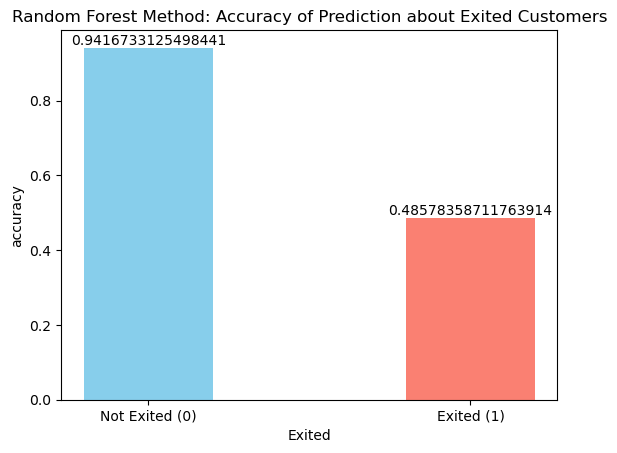

In [26]:
plotting(rf_accuracy_zero, rf_accuracy_one, 'Random Forest Method')

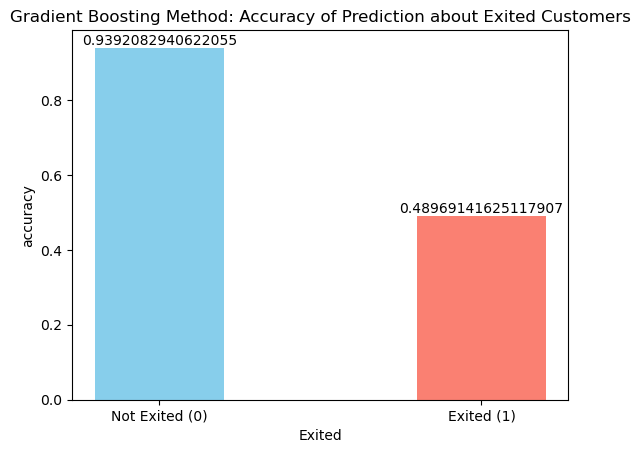

In [27]:
plotting(gb_accuracy_zero, gb_accuracy_one, 'Gradient Boosting Method')

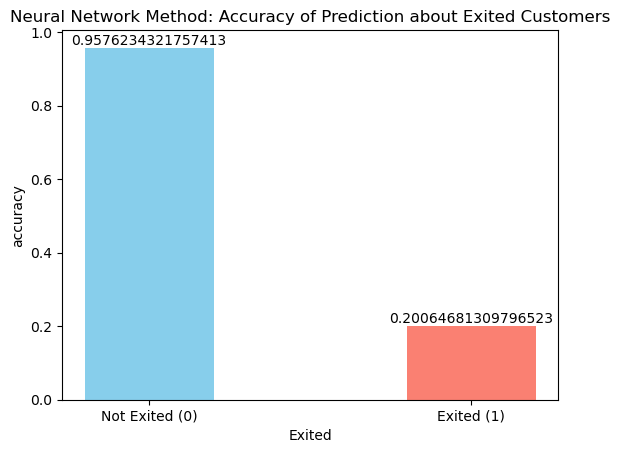

In [28]:
plotting(nn_accuracy_zero, nn_accuracy_one, 'Neural Network Method')